## 앙상블 학습(Ensemble Learning) 
여러 개의 분류기(Classifier)를 생성하고 그 예측을 결합함으로써 보다 정확한 최종예측을 도출하는 기법

정형데이터 분류시 앙상블은 뛰어난 성능을 나타냄

XGboost, LightGBM

앙상블 학습의 유형은 전통적으로 보팅(Voting), 배깅(Bagging), 부스팅(Boosting)의 세 가지로 나 눌 수 있으며, 이 외에도 스태깅을 포함한 다양한 앙상블 방법이 있음

보팅과 배깅은 여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식. 보깅은 서로 다른 알고리즘을 가진 분류기를 결합하는 것, 배깅은 각각의 분류기가 모두 같은 유형의 알고리즘이지만, 데이터 샘플링을 서로 다르게 가져가면서 학습을 수행(랜덤 포레스트 알고리즘).

개별 Classifier에게 데이터를 샘플링 해서 추출하는 방식을 부트스트래핑(Bootstrapping) 분할 방식. 중첩 허용. 

부스팅은 여러 개의 분류기가 순차적으로 학습을 수행하되, 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해서는 올바르게 예측할 수 있도록 다음 분류기에게는 가중치(weight)를 부여하면서 학습과 예측을 진행하는 것. 계속해서 분류기에게 가중치를 부스팅하면서 학습을 진행하기에 부스팅 방식으로 불림. 예측 성능이 뛰어나 앙상블 학습을 주도하고 있으며 대표적인 부스팅 모듈로 그래디언트 부스트, XGBoost(eXtra Gradient Boost), LightGBM(Light Gradient Boost)이 있음.

스태킹은 여러 가지 다른 모델의 예측 결괏값을 다시 학습 데이터로 만들어서 다른 모델(메타 모델)로 재학습시켜 결과를 예측하는 방법.


## 보팅 유형 - 하드 보팅(Hard Voting)과 소프트 보팅(Soft Voting)
하드 보팅을 이용한 분류는 다수결의 원칙과 같음. 예측된 결과값들 중 다수의 분류기가 결정한 예측값을 최종 보팅 결괏값으로 선정. 

소프트 보팅은 분류기들의 레이블 값 결정 확률을 모두 더하여 이를 평균해서 이들 중 확률이 가장 높은 레이블 값을 최종 보팅 결괏값으로 선정. 일반적으로 이게 활용됨.


## 보팅 분류기(Voting Classifier)
사이킷런에서는 보팅 방식의 앙상블을 구현한 VotingClassifier 클래스 제공

위스콘신 유방암 데이터 세트를 예측 분석

In [2]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [3]:
lr_clf = LogisticRegression(solver = 'liblinear')
knn_clf = KNeighborsClassifier(n_neighbors = 8)

vo_clf = VotingClassifier(estimators = [('LR',lr_clf),('KNN',knn_clf)],voting = 'soft')

X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,test_size = 0.2, random_state = 156)

# VotingClassifier 학습/예측/평가.
vo_clf.fit(X_train,y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도:{0:.4f}'.format(accuracy_score(y_test,pred)))

# 개별 모델에 대한 예측/평가
classifier = [lr_clf,knn_clf]
for classifier in classifier:
    classifier.fit(X_train,y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도:{1:.4f}'.format(classifier,accuracy_score(y_test,pred)))

# 보팅 분류기가 정확도가 조금 더 높게 나옴. 항상 그런 것은 아님. 

Voting 분류기 정확도:0.9561
LogisticRegression(solver='liblinear') 정확도:0.9474
KNeighborsClassifier(n_neighbors=8) 정확도:0.9386


## 랜덤 포레스트 
배깅(bagging, bootstrap aggregating)은 앞에서 소개한 보팅과는 다르게, 같은 알고리즘으로 여러개의 분류기를 만들어서 보팅으로 최종 결정을 하는 알고리즘. 배깅의 대표적인 알고리즘이 랜덤 포레스트. 랜덤 포레스트의 기반 알고리즘은 결정 트리로서, 결정 트리의 쉽고 직관적인 장점을 가지고 있음. 

랜덤포레스트는 여러 개의 결정트리 분류기가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해 개별적으로 학습을 진행한 뒤 최종적으로 모든 분류기가 보팅을 통해 예측 결정. 데이터가 일부 중첩되는데, 이렇게 여러 개의 데이터세트를 중첩되게 분리하는 것을 부트스트레핑이라함. 서브세트의 데이터 건수는 전체 데이터 건수와 동일하지만, 개별 데이터가 중첩되어 있음. 

사이킷런은 RandomForestClassifier 클래스를 통해 랜덤포레스트 기반의 분류를 지원 

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )를 이용해 학습/테스트용 DataFrame 반환
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt']) 
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer') 
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] >0 else x[0] , axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1) 
    return new_feature_name_df
    
def get_human_dataset():
    # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('/Users/kileylee/Desktop/ESAA/assignment/human_activity/features.txt',sep='\s+',header=None,
                                  names=['colum_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    
    # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
    X_train = pd.read_csv('/Users/kileylee/Desktop/ESAA/assignment/human_activity/train/X_train.txt',sep='\s+',names = feature_name)
    X_test = pd.read_csv('/Users/kileylee/Desktop/ESAA/assignment/human_activity/test/X_test.txt',sep='\s+',names = feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
    y_train = pd.read_csv('/Users/kileylee/Desktop/ESAA/assignment/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('/Users/kileylee/Desktop/ESAA/assignment/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state = 0, max_depth = 8)
rf_clf.fit(X_train,y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}' .format(accuracy))

랜덤 포레스트 정확도: 0.9192


## 랜덤 포레스트 하이퍼 파라미터 및 튜닝
* n_estimators: 랜덤 포레스트에서 결정 트리의 개수를 지정. 디폴트 10. 많이 설정할수록 좋은 성능 but 또 무조건 향상되는 것도 아님.
* max_features: 랜덤 포레스트의 트리를 분할하는 피처를 참조할 때 전체 피처가 아니라 sqrt(전체 피처 개수)만큼 참조.
* max_depth, min_samples_leaf, min_samples_split: 결정 트리에서 과적합을 개선하기 위해 사용되는 파라미터가 랜덤 포레스트에도 똑같이 적용

In [5]:
from sklearn.model_selection import GridSearchCV

params = {
        'max_depth' : [8,16,24],
        'min_samples_leaf' : [1,6,12],
        'min_samples_split' : [2,8,16]
}
y_train = y_train.values.ravel()

rf_clf = RandomForestClassifier(n_estimators = 100,random_state = 0, n_jobs = -1) #n_jobs = -1  :CPU 코어를 통해 학습할 수 있음
grid_cv = GridSearchCV(rf_clf,param_grid = params,cv=2,n_jobs = -1) 
grid_cv.fit(X_train,y_train)

print('최적 하이퍼 파라미터:\n',grid_cv.best_params_)
print('최고 예측 정확도:{0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 24, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도:0.9162


In [6]:
rf_clf1 = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 6, min_samples_split = 2, max_depth=16, random_state = 0)
rf_clf1.fit(X_train,y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0: .4f}'.format(accuracy_score(y_test , pred)))

예측 정확도:  0.9264


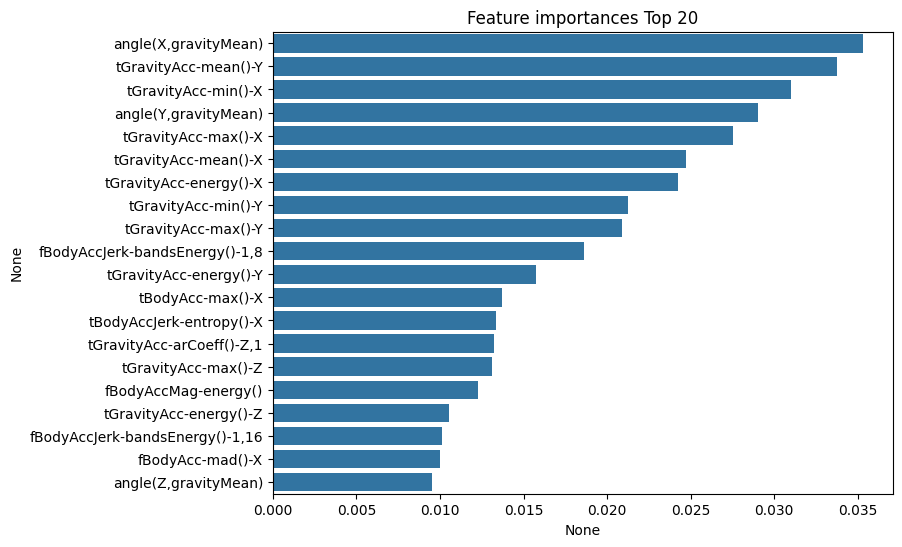

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize = (8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index) 
plt.show()

## GBM(Gradient Boosting Machine) 
부스팅 알고리즘은 여러 개의 약한 학습기를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치를 통해 오류를 개선해 나가면서 학습하는 방식. 

부스팅의 대표적인 구현은 에이다 부스트, 그레이디언트 부스트. 둘은 비슷하나, 그레이디언트 부스트는 가중치 업데이트를 경사 하강법을 이용하는 것이 가장 큰 특징. 

GBM은 CART(Classification and Regression Trees) 기반의 다른 알고리즘과 마찬가지로 분류는 물론이고, 회귀도 가능.

사이킷런에서는 GBM 기반 분류를 위해 GradientBoostingClassifier 클래스를 제공

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train,X_test,y_train,y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(X_train,y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f} 초'.format(time.time() - start_time))

# 랜덤포레스트보다 정확도는 높으나 수행 시간이 오래 걸린다는 단점.

GBM 정확도: 0.9393
GBM 수행 시간: 585.3 초


## GBM 하이퍼 파라미터 소개
* n_estimators
* max_depth
* max_features
* loss : 경사 하강법에서 사용할 비용 함수. 특별한 이유가 없으면 기본값인 ‘deviance’를 그대로 적용
* learning_rate : 학습을 진행할때마다 적용하는 학습률. 0~1 사이 지정. 디폴트는 0.1. n_estimators와 상호 보완적으로 조합해 사용. lr 작게, n_estimator 크게하면 예측 성느이 좋아질 수 있으나, 수행시간이 너무 오래 걸린다는 단점이 있음.
* n_estimators : weak learner의 개수. 많을수록 예측 성능이 좋아지지만, 수행시간 오래걸림. 디폴트 100.
* subsample : weak learner가 학습에 사용하는 데이터의 샘플링 비율. 디폴트 1(전채 학습 데이터를 기반으로 학습). 과적합이 염려될 경우 1보다 작은 값으로 설정.  


## XGBoost(eXtra Gradient Boost)
트리 기반 앙상블 학습에서 가장 각광받고 있음. GBM에 기반하고 있지만 느린 수행 시간 및 과적합 규제 부재의 문제 해결. CPU 환경에서 병렬 학습이 가능해 기존 GBM보다 빠르게 학습 가능. 
* 뛰어난 예측 성능
* GBM 대비 빠른 수행 시간
* 과적합 규제(Regularization)
* Tree Pruning : XGBoost도 max_depth 파라미터로 분할 깊이를 조정하기도 하지만, tree pruning으로 더 이상 긍정 이득이 없는 분할을 가지치기 해서 분할 수를 더 줄이는 추가적인 장점 을 가지고 있음
* 자체 내장된 교차 검증
* 결손값 자체 처리


XGBoost 패키지의 사이킷런 래퍼 클래스는 XGBClassifier와 XGBRegressor

초기의 독자적인 XGBoost 프레임워크 기반의 XGBoost를 **파이썬 래퍼 XGBoost 모듈**, 사이킷런과 연동되는 모듈을 **사이킷런 래퍼 XGBoost 모듈**

In [9]:
pip install xgboost==1.6.0

Note: you may need to restart the kernel to use updated packages.


In [10]:
import xgboost as xgb
from xgboost import XGBClassifier

## 파이썬 래퍼 XBGoost 하이퍼 파라미터

* 일반 파라미터 : 일반적으로 실행 시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터로서 디폴트 파라미터 값을 바꾸는 경우는 거의 없음
* 부스터 파라미터 : 트리 최적화, 부스팅, regularization
* 학습 테스크 파라미터 : 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터

**주요 일반 파라미터**
* booster : gbtree(tree based model), gblinear(linear model) 디폴트는 gbtree
* silent : 디폴트는 0. 출력 메세지를 나타내고 싶지 않을 경우 1.
* nthread : CPU 실행 스레드의 개수를 조정하며, 디폴트는 CPU 전체 스프레드 다 사용. 멀티 코어/스레드 CPU 시스템에서 전체 CPU를 사용하지 않고 일부 CPU만 사용해 ML 애플리케이션을 구동하는 경우에 변경

**주요 부스터 파라미터**
* eta : [default = 0.3, alias:learning_rate] # 사이킷런 래퍼 클래스를 이용할 경우 learning_rate, default는 0.1
* num_boost_rounds : GBM의 n_estimator와 같은 파라미터
* min_child_weight[default=0: 트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요한 데이터들의 weight 총합. min_child_weight이 클수록 분할을 자제함. 과적합을 조절하기 위해 사용.
* gamma[default = 0, alias : min_split_loss]. 리프 노드를 더 나눌지를 결정할 최소손실감소값. 해당 값보다 큰 손실(loss)이 감소된 경우에 리프 노드를 분리합니다. 값이 클수록 과적합 감소 효과
* max_depth[default=6]: 트리 기반 알고리즘의 max_depth와 같음. 0을 지정하면 깊이에 제한이 없음. Max_depth가 높으면 특정 피처 조건에 특화되어 룰 조건이 만들어지므로 과적합 가능성이 높아지며 보통은 3〜 10 사이의 값을 적용.
* sub_sample[default=1]: GBM의 subsample과 동일. 트리가 커져서 과적합되는 것을 제어하기 위해 데이터를 샘플링하는 비율을 지정. sub_sample=0.5로 지정하면 전체 데이터의 절반을 트리를 생성하는 데 사용. 0에 서 1 사이의 값이 가능하나 일반적으로 0.5 〜 1 사이의 값을 사용.
* colsample_bytree[default=l]: GBM의 max_features와 유사합니다. 트리 생성에 필요한 피처(칼럼)를 임의로 샘플링 하는 데 사용. 매우 많은 피처가 있는 경우 과적합을 조정하는 데 적용.
* lambda [default=1, alias: reg_lambda]: L2 Regularization 적용 값. 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있음.
* alpha [default=0, alias: reg_alpha]: L1 Regularization 적용 값. 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있음.
* scale_pos_weight[default=1]: 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터

**학습 테스크 파라미터**
* objective : 손실함수 정의. 이진분류인지 다중분류인지에 따라 다양한 손실 함수가 있음
* binary:logistic : 이진분류 적용
* multi:softmax : 다중분류 적용. 레이블 클래스 개수인 num_class 파라미터 지정. 
* eval_metric : 검증에 사용되는 함수 정의. 회귀는 rmse, 분류일 경우 error.

예시
* rmse: Root Mean Square Error
* mae: Mean Absolute Error
* logloss: Negative logLikelihood
* error: Binary classification error rate (0.5 threshold)
* merror: Multiclass classification error rate
* mlogloss: Multiclass logloss
* auc: Area under the curve

In [11]:
import xgboost 
print(xgboost.__version__)

1.6.0


## 파이썬 래퍼 XGBoost 적용 -  위스콘신 유방암 예측

## 파이썬 래퍼 XGBoost - 위스콘신 유방암 예측

## 파이썬 래퍼 XGBoost - 위스콘신 유방암 예측

자체적으로 교차 검증, 성능 평가, 피처 중요도 시각화, 조기 중단 기능 가지고 있음

In [12]:
import xgboost as xgb
from xgboost import plot_importance # 피처의 중요도를 시각화해주는 모델
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data = features,columns = dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [13]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [14]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label임. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출.
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train,X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.2,random_state = 156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
# XGBoost가 제공하는 기능인 검증 성능 평가와 조기 중단을 수행해보기 위해
X_tr,X_val,y_tr,y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=156)

print(X_train.shape , X_test.shape) 
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


파이썬 래퍼 XGboost와 사이킷런의 가장 큰 차이점은 XGBoost 만의 전용 데이터 객체인 DMatrix를 사용한다는 것.

넘파이, 데이터프레임, Series,libsvm txt 포맷 파일, xgboost 이진 버퍼 파일 기반으로 DMatrix 생성 가능.

DMatrix의 주요 파라미터에는 data(피처 데이터 세트), label(분류 - 레이블 데이터 세트/회귀 - 종솟값 데이터 세트)

In [15]:
# 학습, 검증, 테스트용 DMatrix를 생성.
dtr = xgb.DMatrix(data = X_tr,label = y_tr)
dval = xgb.DMatrix(data = X_val,label = y_val)
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [16]:
params = {
        'max_depth' : 3,
        'eta' : 0.05,
        'objective' : 'binary:logistic',
        'eval_metric' : 'logloss'
}
num_rounds = 500

In [17]:
eval_list = [(dtr,'train'),(dval,'eval')] # [(dval,'eval')] 만 명기해도 무방

# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain = dtr, num_boost_round = num_rounds, early_stopping_rounds = 50, evals = eval_list)

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52930
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31892	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

In [18]:
pred_probs = xgb_model.predict(dtest) # 예측 결과값이 아닌 예측 확률 반환
print('predict( ) 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

predict( ) 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]


In [19]:
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:',preds[:10])

예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,f1_score,roc_auc_score

def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1{3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test,preds,pred_probs)

오차행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F10.9677, AUC: 0.9465


xgboost plot_importance() 시각화

f스코어(해당 피처가 분할시 얼마나 많이 사용되었는지) 기반으로 함

사이킷런은 Estimator 객체의 feature_importances 속성을 이용해 직접 시각화 코드를 작성해야하지만, xgboost는 plot_importance()를 이용해 바로 피처 중요도를 시각화할 수 있음. 인자로는 학습이 완료된 모델 객체 및 맷플롯립의 ax 객체를 입력하기만 하면 됨.

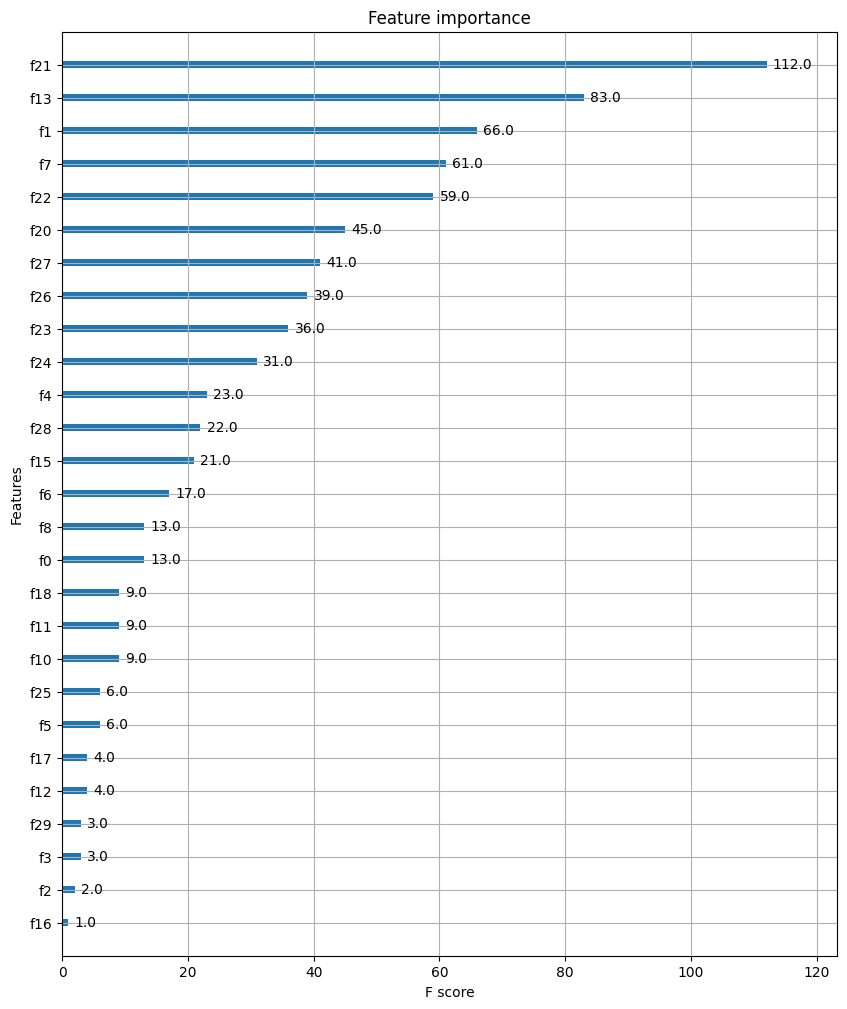

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize = (10,12))
plot_importance(xgb_model,ax=ax)
plt.show()

# 피처명으로 나타나지 않고 f{}로 나타난 이유 : xgboost를 DataFrame이 아닌 넘파이 기반의 피처 데이터로 학습시 피처명을 제대로 알 수 없으므로 피처 순서별로 f자 뒤에 숫자를 붙여서 피처명을 나타냄

결정 트리에서 보여준 트리 기반 규칙 구조도 xgboost에서 시각화할 수 있음.

xgboost의 to_graphviz() API 이용.

파이썬 래퍼 XGBoost는 사이킷런의 GridSearchCV와 유사하게 데이터 세트에 대한 교차 검증 수행 후 최적 파라미터를 구할 수 있는 방법으로 cv() API 제공

xgboost.cv(params, dtrain, num_boost_ro나nd=10, nfold=3, stratified=False, folds=Nonez metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=Non은, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=Gz callbacks=None, shuffle=True)

* params (dict) : 부스터 파라미터

* dtrain (DMatrix) : 학습 데이터

* num_boost_round (int): 부스팅 반복 횟수

* nfold (int) : CV폴드개수

* stratified (bool) : CV 수행 시 층화 표본 추출(stratified sampling) 수행 여부

* metrics (string or list of strings) : CV 수행 시 모니터링 할 성능 평가지표

* early_stopping_rounds (int) : 조기 중단을 활성화시킴. 반복 횟수 지정.

반환값은 DataFrame 형태.

## 사이킷런 래퍼 XGBoost 개요 및 적용
다른 머신러닝 알고리즘과 비슷하게 유틸리티를 그대로 사용할 수 있고 알고리즘 클래스만 XGBoost 래퍼 클래스. 

사이킷런울 위한 래퍼 XGBoost는 분류를 위한 래퍼 클래스인 XGBClassifier, 회귀를 위한 XGBRegressor.

* eta — learning_rate

* sub_sample — subsample

* lambda — reg_lambda

* alpha — reg_alpha

* num_boost_round - n_estimators

In [22]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.05, max_depth = 3, eval_metric = 'logloss')
xgb_wrapper.fit(X_train,y_train,verbose = True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [24]:
get_clf_eval(y_test,w_preds,w_pred_proba)

오차행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F10.9744, AUC: 0.9530


사이퍼 래퍼 XGBoost 기반 조기 중단

조기 중단 파라미터를 fit()에 입력하면 됨.

In [25]:
from xgboost import XGBClassifier
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.05, max_depth = 3)
evals = [(X_tr,y_tr),(X_val,y_val)]
xgb_wrapper.fit(X_tr,y_tr,early_stopping_rounds = 50,eval_metric = 'logloss',eval_set = evals, verbose = True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

In [26]:
get_clf_eval(y_test , ws50_preds, ws50_pred_proba)

오차행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F10.9677, AUC: 0.9465


In [30]:
# early_stopping_rounds를 10으로 설정하고 재학습.
xgb_wrapper.fit(X_tr,y_tr, early_stopping_rounds = 10, eval_metric = 'logloss', eval_set = evals, verbose = True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

# 정확도가 early_stopping_rounds = 50 보다 낮음.

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

피처의 중요도를 시각화하는 plot_importance() API에 사이킷런 래퍼 클래스를 입력해도 앞선 파이썬 래퍼 클래스를 입력한 결과와 똑같이 시각화 결과 도출.

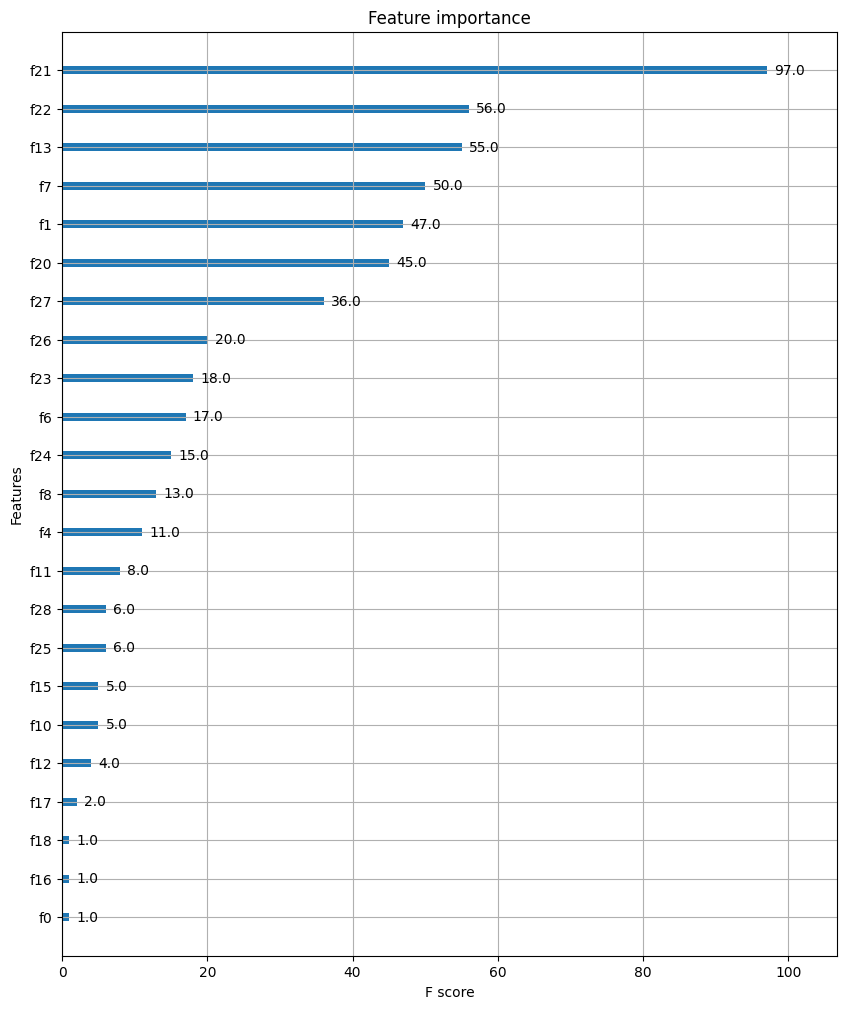

In [32]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize = (10,12))
plot_importance(xgb_wrapper,ax=ax)
plt.show()